Importing necessary libraries

In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import itertools

from collections import Counter
from matplotlib.colors import ListedColormap
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
%matplotlib inline

Loading the csv filed using pandas

In [257]:
# Load the april OBP CSV
april_stats = pd.read_csv(r'C:\College\1 IB\EE\april.csv', encoding='cp861', sep=';')

# Load the end-of-season OBP CSV
end_season_stats = pd.read_csv(r'C:\College\1 IB\EE\Fullseason.csv', encoding='cp861', sep=';')

Checking for name duplicates and remove them

In [260]:
april_stats = april_stats.drop_duplicates(subset=['Name'])
end_season_stats = end_season_stats.drop_duplicates(subset=['Name'])

Finding the names that april_stats and end_season_stats share

In [263]:
common_players = set(april_stats['Name']).intersection(set(end_season_stats['Name']))

Filter new datasets with only names that appear in both april_stats and end_season_stats

In [266]:
# Filter both DataFrames to only include the common players
april_stats_filtered = april_stats[april_stats['Name'].isin(common_players)]
end_season_stats_filtered = end_season_stats[end_season_stats['Name'].isin(common_players)]

Check the lengths of the filtered datasets

In [269]:
assert len(april_stats_filtered) == len(end_season_stats_filtered), "The number of PlayerIDs still do not match after filtering."

Select the columns to merge from both datasets to form the final merged dataset

In [272]:
selected_columns_april = ['Name', 'Team', 'G', 'PA', 'HR', 'R', 'RBI', 'SB', 'BB%', 'K%', 'ISO', 'BABIP', 'AVG', 'SLG', 'wOBA', 'wRC+', 'BsR', 'Off', 'Def', 'WAR']
april_stats_selected = april_stats_filtered[selected_columns_april]
end_season_stats_selected = end_season_stats_filtered[['Name', 'OBP']]

Merging the datasets on players' names

In [275]:
merged_stats = pd.merge(april_stats_selected, end_season_stats_selected, on='Name')

Distribution analysis

Histogram of OBP

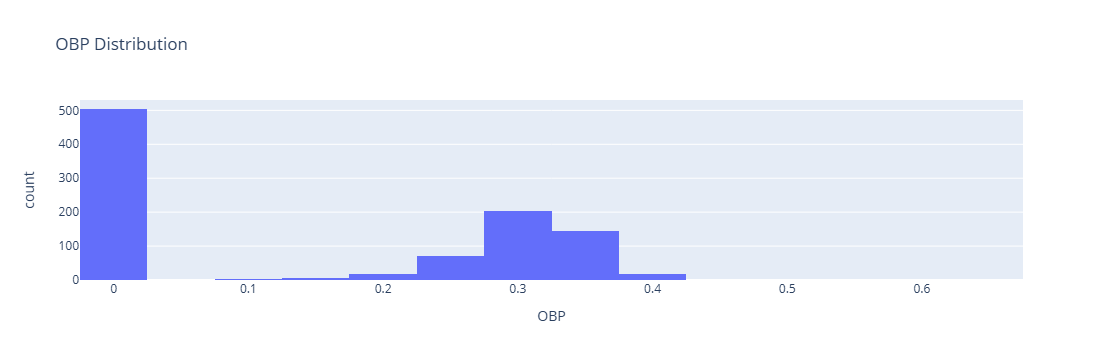

In [279]:
# Creating the histogram
fig = px.histogram(merged_stats, x='OBP', nbins=20, title='OBP Distribution', labels={'OBP': 'OBP'})

# Displaying the plot
fig.show()

Remove the 0s from the dataset

In [282]:
merged_stats = merged_stats[merged_stats['OBP'] != 0]
merged_stats = merged_stats.reset_index(drop=True)
merged_stats

,Name,Team,G,PA,HR,R,RBI,SB,BB%,K%,...,BABIP,AVG,SLG,wOBA,wRC+,BsR,Off,Def,WAR,OBP
0,Matt Chapman,TOR,26,109,5,17,20,1,12.8%,22.9%,...,0.469,0.372,0.691,0.479,214.0,-0.4,14.5,0.8,1.9,0.330
1,Sean Murphy,ATL,22,91,6,16,16,0,17.6%,24.2%,...,0.311,0.274,0.616,0.434,175.0,-0.3,8.1,4.1,1.5,0.365
2,Thairo Estrada,SFG,25,108,4,19,10,7,4.6%,20.4%,...,0.405,0.340,0.530,0.395,154.0,1.0,8.2,3.1,1.5,0.315
3,Mike Trout,LAA,26,120,7,20,18,0,10.8%,28.3%,...,0.406,0.317,0.606,0.423,172.0,0.0,10.4,0.4,1.5,0.367
4,Ronald Acu±a Jr.,ATL,26,119,4,23,14,12,13.4%,15.1%,...,0.400,0.353,0.559,0.429,172.0,1.6,12.1,-1.3,1.5,0.416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,JosΘ Abreu,HOU,26,112,0,6,11,0,2.7%,23.2%,...,0.305,0.231,0.269,0.231,42.0,-0.4,-8.2,-2.4,-0.7,0.296
460,Michael Massey,KCR,23,77,0,4,5,1,1.3%,37.7%,...,0.277,0.176,0.189,0.163,-10.0,0.3,-9.9,0.4,-0.7,0.274
461,Aledmys Dφaz,OAK,24,89,1,7,5,1,5.6%,21.3%,...,0.161,0.134,0.195,0.185,14.0,-0.4,-9.6,-0.4,-0.7,0.280
462,Oscar Gonzalez,CLE,21,65,1,4,4,0,3.1%,20.0%,...,0.184,0.159,0.270,0.196,19.0,0.4,-5.9,-3.5,-0.7,0.239


Histogram of SLG

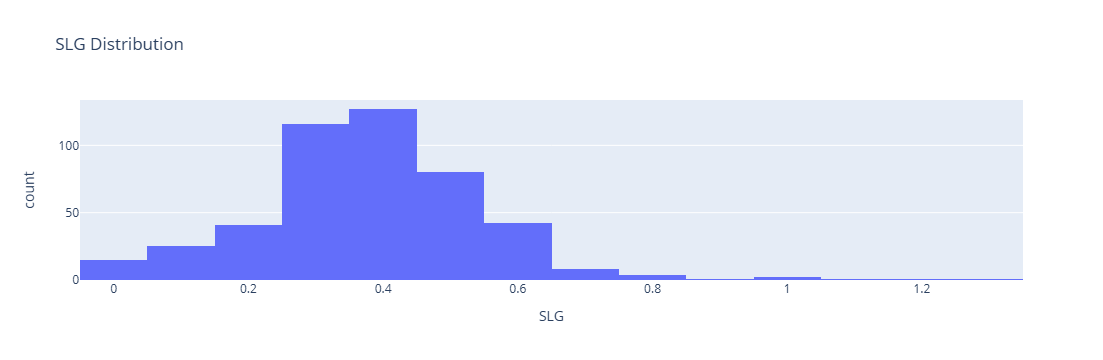

In [285]:
fig = px.histogram(merged_stats, x='SLG', nbins=20, title='SLG Distribution', labels={'SLG': 'SLG'})
fig.show()

Histogram of AVG

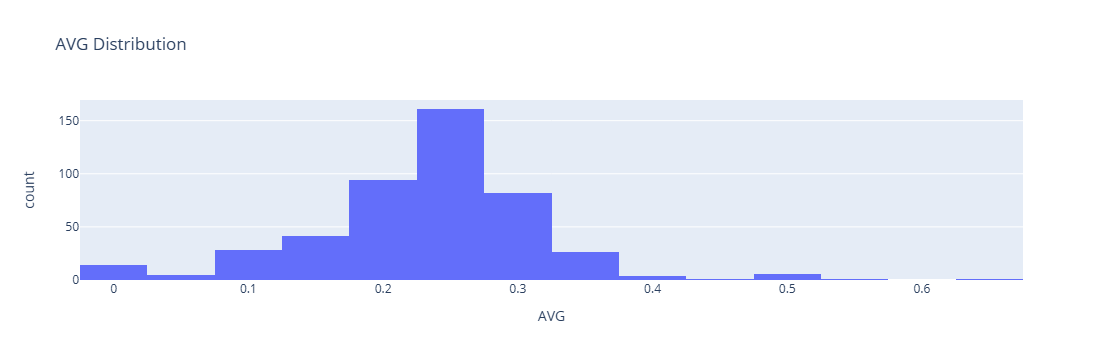

In [288]:
fig = px.histogram(merged_stats, x='AVG', nbins=20, title='AVG Distribution', labels={'AVG': 'AVG'})
fig.show()

Historgram of R

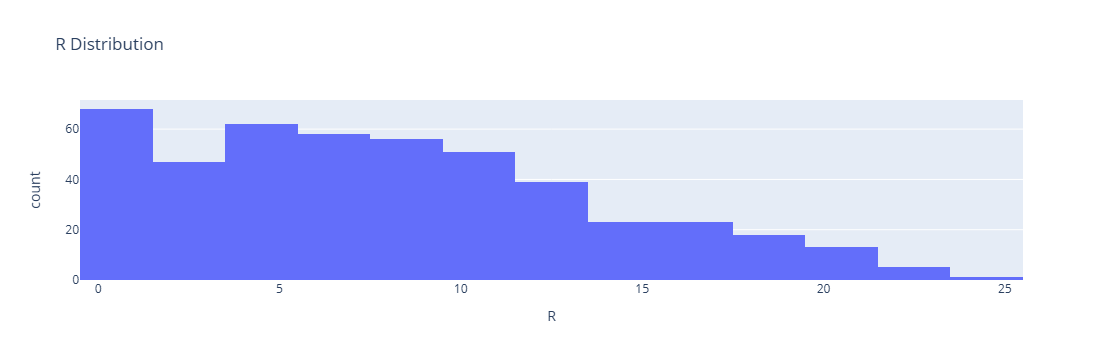

In [291]:
fig = px.histogram(merged_stats, x='R', nbins=20, title='R Distribution', labels={'R': 'R'})
fig.show()

Building the model

Splitting the dataset into a training set and a testing set

In [295]:
#Split dataset
X = merged_stats[['AVG', 'SLG', 'R']]
y = merged_stats['OBP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Standardizing the training and testing datasets

In [298]:
#Scaling
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

Defining the KNNR model

In [301]:
#Define model
regressor = KNeighborsRegressor(n_neighbors=4, p=2, metric ='euclidean') #p=2 is using euclidean distance and K=4
regressor.fit(X_train, y_train)

KNeighborsRegressor(metric='euclidean', n_neighbors=4)

Make predictions on the test set

In [304]:
y_pred = regressor.predict(X_test)

Evaluating the model

In [307]:
mse = mean_squared_error(y_test, y_pred)
mse

0.002310130376344086

Creating a function for predicting new values with input k

In [310]:
def get_error(k):
    #Split dataset
    X = merged_stats[['AVG', 'SLG', 'R']]
    y = merged_stats['OBP']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

    #Scaling
    scaler_X = StandardScaler()
    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)

    #Defining the model
    regressor = KNeighborsRegressor(n_neighbors=k, p=2, metric ='euclidean') #p=2 is using euclidean distance
    regressor.fit(X_train, y_train)

    #Making predictions
    y_pred_test = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    return (mse_test, mse_train)

Iterating with different values of k

In [313]:
test_pred = []
train_pred = []
k = []
for i in range(1, 20):
    errors = get_error(i)
    #Adding the values to the lists
    test_pred.append(errors[0])
    train_pred.append(errors[1])
    k.append(i)

Plotting a graph of MSE against K

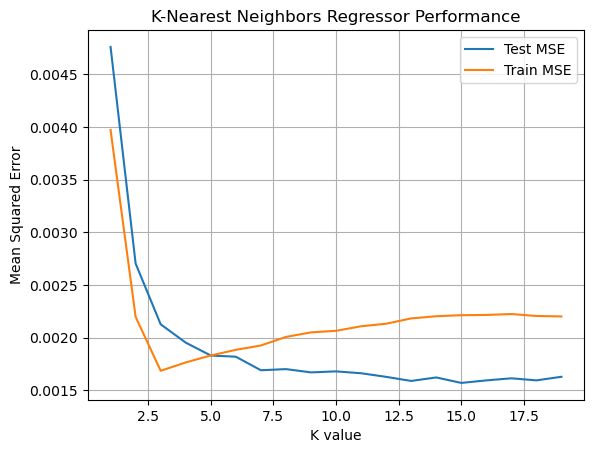

In [316]:
plt.plot(k, test_pred, label='Test MSE')
plt.plot(k, train_pred, label='Train MSE')
plt.xlabel('K value')
plt.ylabel('Mean Squared Error')
plt.title('K-Nearest Neighbors Regressor Performance')
plt.grid(True)
plt.legend()
plt.show()

After analyzing, the best value of K is 3, and the MSE value is

In [319]:
regressor = KNeighborsRegressor(n_neighbors=3, p=2, metric ='euclidean') #p=2 is using euclidean distance
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
mse_3 = mean_squared_error(y_test, y_pred)
mse_3

0.002478767025089606

Therefore, lets try to test the MSE on other combinations of features of 3 using the best K value

Getting all combinations of 3 that is relevant to the target variable OBP

In [323]:
combinations = list(itertools.combinations(['HR', 'R', 'RBI', 'SB', 'AVG', 'SLG'], 3))
print(combinations)

[('HR', 'R', 'RBI'), ('HR', 'R', 'SB'), ('HR', 'R', 'AVG'), ('HR', 'R', 'SLG'), ('HR', 'RBI', 'SB'), ('HR', 'RBI', 'AVG'), ('HR', 'RBI', 'SLG'), ('HR', 'SB', 'AVG'), ('HR', 'SB', 'SLG'), ('HR', 'AVG', 'SLG'), ('R', 'RBI', 'SB'), ('R', 'RBI', 'AVG'), ('R', 'RBI', 'SLG'), ('R', 'SB', 'AVG'), ('R', 'SB', 'SLG'), ('R', 'AVG', 'SLG'), ('RBI', 'SB', 'AVG'), ('RBI', 'SB', 'SLG'), ('RBI', 'AVG', 'SLG'), ('SB', 'AVG', 'SLG')]


Finding the MSE of each combination

Defining a function with the best k value gotten from before

In [327]:
def get_mse(combination):
    #Split dataset
    X = merged_stats[combination]
    y = merged_stats['OBP']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    #Scaling
    scaler_X = StandardScaler()
    X_train = scaler_X.fit_transform(X_train)
    X_test = scaler_X.transform(X_test)

    #Defining the model
    regressor = KNeighborsRegressor(n_neighbors=3, p=2, metric ='euclidean') #p=2 is using euclidean distance
    regressor.fit(X_train, y_train)

    #Making predictions
    y_pred_test = regressor.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    return mse_test

Find the MSE

In [330]:
combinations_mse = []
lowest_mse_combinations = []
for combo in combinations:
    temp_mse = get_mse(list(combo))
    combinations_mse.append(temp_mse)
print(combinations_mse)

[0.004287090800477898, 0.0068135925925925924, 0.0021503990442054964, 0.0025847933094384707, 0.001830980884109916, 0.0038410035842293914, 0.0023032078853046593, 0.004070225806451613, 0.002168960573476702, 0.002811861409796893, 0.0023479880525686973, 0.0021102437275985655, 0.0028159151732377536, 0.004366397849462368, 0.0027395400238948626, 0.0023996690561529275, 0.0022850896057347663, 0.002447571087216248, 0.002131037037037037, 0.003239118279569891]


Where is it the minimum?

In [333]:
print(min(combinations_mse))
combination_index = combinations_mse.index(min(combinations_mse))
lowest_mse_combinations.append(combinations[combination_index])
print(lowest_mse_combinations)

0.001830980884109916
[('HR', 'RBI', 'SB')]


Now, I want to find out which features appears the most in the combinations with the lowest MSE

Creating the function

In [337]:
def get_frequent_feature():
    combinations_mse = []
    for combo in combinations:
        temp_mse = get_mse(list(combo))
        combinations_mse.append(temp_mse)
    combination_index = combinations_mse.index(min(combinations_mse))
    lowest_mse_combinations.append(combinations[combination_index])

Iterating 60 times to see which 2 features pops up the most

In [340]:
for i in range(0, 60):
    get_frequent_feature()

Counting the frequency of each feature in the triplets and getting the two most frequent features

In [343]:
# Count the frequency of each feature in the triplets
feature_counter = Counter()
for triplet in lowest_mse_combinations:
    feature_counter.update(triplet)

# Get the two most frequent features
most_common_features = feature_counter.most_common(2)
print(most_common_features)

[('AVG', 42), ('SLG', 34)]


Create a pie chart to show the trend of each feature

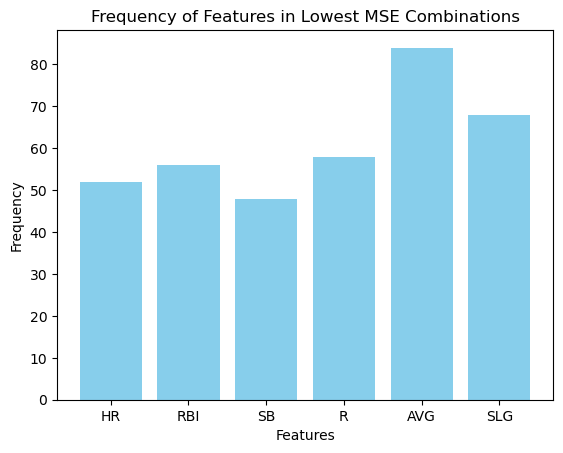

In [346]:
for triplet in lowest_mse_combinations:
    feature_counter.update(triplet)

# Extract the features and their counts
features = list(feature_counter.keys())
counts = list(feature_counter.values())

# Create a bar chart for the frequencies of all features
fig, ax = plt.subplots()
ax.bar(features, counts, color='skyblue')
ax.set_xlabel('Features')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Features in Lowest MSE Combinations')
ax.set_xticks(features)
ax.set_xticklabels(features)

plt.show()

Therefore these are the features with the most significant contributions

Graphing the data distribution

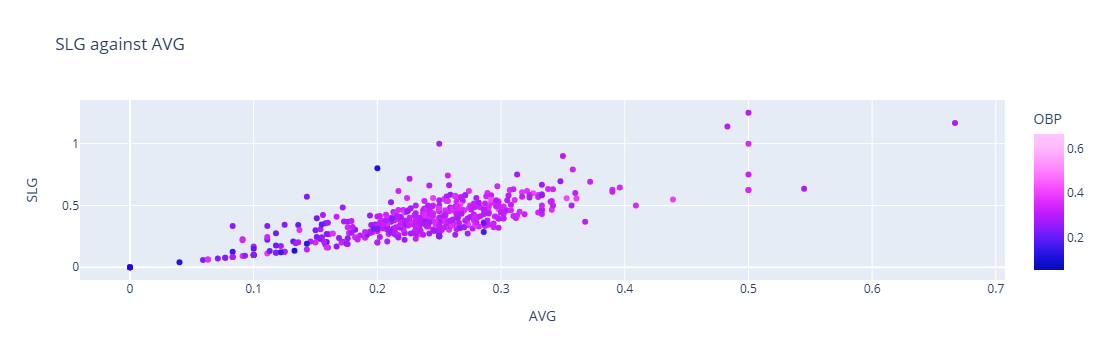

In [359]:
x_data = merged_stats['AVG']
y_data = merged_stats['SLG']
color = merged_stats['OBP']

slope, intercept = np.polyfit(x_data, y_data, 1)
line_of_best_fit = slope * x_data + intercept

# Create the 2D scatter plot
fig = px.scatter(
    merged_stats, 
    x='AVG', 
    y='SLG',
    color='OBP', 
    color_continuous_scale='Plotly3',
    title='SLG against AVG',
    labels={'AVG': 'AVG', 'SLG': 'SLG'}
)

fig.show()

Now, what happens to the model's MSE when we only use these 2 features?

In [361]:
#Split dataset
X = merged_stats[['AVG', 'SLG']]
y = merged_stats['OBP']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

#Scaling
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

#Defining the model
regressor = KNeighborsRegressor(n_neighbors=6, p=2, metric ='euclidean') #p=2 is using euclidean distance
regressor.fit(X_train, y_train)

#Making predictions
y_pred_test = regressor.predict(X_test)
mse_2 = mean_squared_error(y_test, y_pred_test)

print("2 features:", mse_2)
print("3 features:", mse_3)

2 features: 0.001947350955794504
3 features: 0.002478767025089606


MSE for 3 features is higher than the MSE for 2 features. This confirms the theory of the curse of dimensionality.

R vs OBP scatter plot

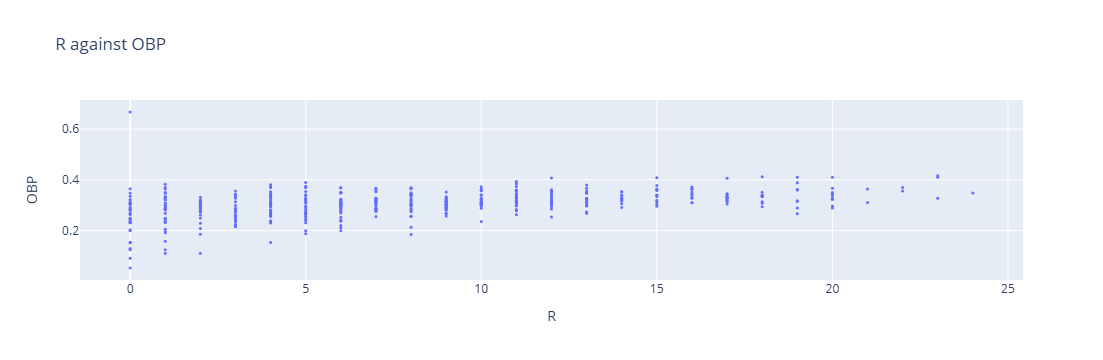

In [ ]:
x_data = merged_stats['R']
y_data = merged_stats['OBP']

slope, intercept = np.polyfit(x_data, y_data, 1)
line_of_best_fit = slope * x_data + intercept

# Create the 2D scatter plot
fig = px.scatter(
    merged_stats, 
    x='R', 
    y='OBP',
    title='R against OBP',
    labels={'R': 'R', 'OBP': 'OBP'}
)

fig.update_traces(marker=dict(size=3),
                  selector=dict(mode='markers'))

fig.show()